In [38]:
import tensorflow as tf
from PIL import Image
import numpy as np
from mtcnn.mtcnn import MTCNN
import cv2
import os
from matplotlib import pyplot
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [39]:
# Reference
# https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/
# Extract the face from the image
def face_extraction(image_address, m, n):
    image = Image.open(image_address).convert('RGB')
    image_array = np.asarray(image)
    # To get the coordinates of the face in the image using MTCNN
    face_cor = MTCNN().detect_faces(image_array)
    # w and h are the width and height
    x_cor, y_cor, w, h = face_cor[0]['box']
    image_array = image_array[y_cor:(y_cor+h), x_cor:(x_cor+w)]
    image = Image.fromarray(image_array)
    image = image.resize((m,n))
    return np.asarray(image)
# Function Call parameters - image, dimensions(x,y)
# face_extraction("elon_musk_1.jpg", 160, 160)

In [40]:
# all extracted face data stored in numpy array
def prepare_dataset(location):
    x_train = list()
    y_train = list()
    for sub_folder in os.listdir(location):
        subfolder_face = list()
        str_location = location + "/" + sub_folder
        if(sub_folder == ".DS_Store"):
            continue
        for files in os.listdir(str_location):
            if(files == ".DS_Store"):
                continue
            file_location = str_location + "/" + files
            #print(file_location)
            # 160,160 is the input dimension of the FaceNet trained model used
            subfolder_face.append(face_extraction(file_location, 160, 160))
        # print(sub_folder, len(subfolder_face))
        x_train.extend(subfolder_face)
        y_train.extend(sub_folder for _ in range(len(subfolder_face)))
    return np.asarray(x_train), np.asarray(y_train)
# function call parameter - image location
# x_train_data, y_train_data = prepare_dataset("dataset/train")

In [41]:
# extract the face feature using FaceNet model
def feature_extraction(x_train_data, model):
    feature_extracted = list()
    for pics in x_train_data:
        pics = pics.astype('float32')
        pics = (pics - pics.mean())/pics.std()
        pics = np.expand_dims(pics, axis=0)
        y_prediction = model.predict(pics)
        feature_extracted.append(y_prediction[0])
    feature_extracted = np.asarray(feature_extracted)
    return feature_extracted
# function call parameter - x_train_data(numpy array), CNN model
# feature_extraction(x_train_data, model)

In [42]:
# Training the SVM model
def SVM_model(x_train_feature, x_test_feature, y_train_data, y_test_data):
    l2_norm = Normalizer(norm='l2')
    x_train_svm = l2_norm.transform(x_train_feature)
    x_test_svm = l2_norm.transform(x_test_feature)
    label_category = LabelEncoder()
    label_category.fit(y_train_data)
    y_train_svm = label_category.transform(y_train_data)
    y_test_svm = label_category.transform(y_test_data)
    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(x_train_svm, y_train_svm)
    y_predict_train = svm_model.predict(x_train_svm)
    y_predict_test = svm_model.predict(x_test_svm)
    # Accuracy calculation
    train_acc = accuracy_score(y_train_svm, y_predict_train)
    test_acc = accuracy_score(y_test_svm, y_predict_test)
    print("Train Accuracy")
    print(train_acc)
    print("Test Accuracy")
    print(test_acc)
    
    # Confusion matrix
    # train_confusion_matrix = confusion_matrix(y_train_svm, y_predict_train)
    # print("train matrix")
    # print(train_confusion_matrix)
    test_confusion_matrix = confusion_matrix(y_test_svm, y_predict_test)
    print("test matrix")
    print(test_confusion_matrix)
    FP = (test_confusion_matrix.sum(axis=0) - np.diag(test_confusion_matrix)).astype(float)
    FN = (test_confusion_matrix.sum(axis=1) - np.diag(test_confusion_matrix)).astype(float)
    TP = (np.diag(test_confusion_matrix)).astype(float)
    TN = (test_confusion_matrix.sum() - (FP + FN + TP)).astype(float)

    # Sensitivity
    true_positive_rate = TP/(TP+FN)
    print("Sensitivity/True Positive Rate")
    print(np.sum(true_positive_rate)/len(true_positive_rate))

    # Specificity or true negative rate
    true_negative_rate = TN/(TN+FP)
    print("Specificity/True Negative Rate")
    print(np.sum(true_negative_rate)/len(true_negative_rate))
    
    return svm_model, label_category

In [43]:
# Training
# Prepare dataset
# print("Training data")
x_train_data, y_train_data = prepare_dataset("dataset/train") # Train
# print("Test data")
x_test_data, y_test_data = prepare_dataset("dataset/test") # Test
print("train data")
print(x_train_data.shape)
print("test data")
print(x_test_data.shape)
# Save train and test features
np.savez_compressed('dataset.npz', x_train_data, y_train_data, x_test_data, y_test_data)
# Load Pre-Trained Model
CNN_model = load_model('keras-facenet/model/facenet_keras.h5')
# feature extraction
x_train_feature = feature_extraction(x_train_data, CNN_model)
x_test_feature = feature_extraction(x_test_data, CNN_model)
print(x_train_feature.shape)
print(x_test_feature.shape)
# Train the SVM model
SVM_model, labels = SVM_model(x_train_feature, x_test_feature, y_train_data, y_test_data)

train data
(248, 160, 160, 3)
test data
(82, 160, 160, 3)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(248, 128)
(82, 128)
Train Accuracy
1.0
Test Accuracy
0.975609756097561
test matrix
[[5 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]]
Sensitivity/True Positive Rate
0.9754901960784315
Specificity/True Negative Rate
0.998462064251538


In [44]:
def face_prediction(image_address, m, n, CNN_model, SVM_model, labels):
    image = Image.open(image_address).convert('RGB')
    image_input = np.asarray(image)
    image_array = image_input
    # To get the coordinates of the face in the image
    face_cor = MTCNN().detect_faces(image_array)
    # len will be 0 - if no face is found in the video
    if len(face_cor) != 0:
        # w and h are the width and height
        x_cor, y_cor, w, h = face_cor[0]['box']
        # face extraction
        image_array = image_array[y_cor:(y_cor+h), x_cor:(x_cor+w)]
        image = Image.fromarray(image_array)
        pyplot.subplot(1, 1, 1)
        pyplot.axis('off')
        pyplot.imshow(image_input)
        image = image.resize((m,n))
        image_array = np.asarray(image)
        image_array = image_array.astype('float32')
        image_array = (image_array - image_array.mean())/image_array.std()
        image_array = np.expand_dims(image_array, axis=0)
        # feature extraction
        image_prediction = CNN_model.predict(image_array)
        l2_norm = Normalizer(norm='l2')
        image_svm_input = l2_norm.transform(image_prediction)
        predict_image = SVM_model.predict(image_svm_input)
        person_name = labels.inverse_transform(predict_image)
    
        # below comment will draw a bounding box around the text and will add text
        img = cv2.rectangle(image_input,(x_cor,y_cor),(x_cor+w,y_cor+h),(0,255,0),4)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,person_name[0],(x_cor+10,y_cor-10), font, .5,(255,0,0),2,cv2.LINE_AA)
        cv2.imwrite("output_" + image_address,cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        return person_name[0]
    else:
        return ""

person in the image is: ben_afflek


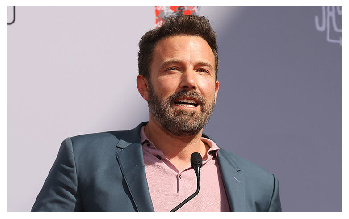

In [50]:
# Image Prediction
person_name = face_prediction("test1_ben.jpg", 160, 160, CNN_model, SVM_model, labels)
print("person in the image is: " + str(person_name))

In [47]:
def face_prediction_video(image_address, m, n, CNN_model, SVM_model, labels):
    #image = Image.open(image_address).convert('RGB')
    image_input = np.asarray(image_address)
    image_array = image_input
    # To get the coordinates of the face in the image
    face_cor = MTCNN().detect_faces(image_array)
    # w and h are the width and height
    if(len(face_cor) != 0 and all(i > 0 for i in face_cor[0]['box'])):
        x_cor, y_cor, w, h = face_cor[0]['box']
        # face extraction
        # print(face_cor[0]['box'])
        # print(type(face_cor[0]['box']))
        image_array = image_array[y_cor:(y_cor+h), x_cor:(x_cor+w)]
        image = Image.fromarray(image_array)
        image = image.resize((m,n))
        image_array = np.asarray(image)
        image_array = image_array.astype('float32')
        image_array = (image_array - image_array.mean())/image_array.std()
        image_array = np.expand_dims(image_array, axis=0)
        # feature extraction
        image_prediction = CNN_model.predict(image_array)
        l2_norm = Normalizer(norm='l2')
        image_svm_input = l2_norm.transform(image_prediction)
        predict_image = SVM_model.predict(image_svm_input)
        person_name = labels.inverse_transform(predict_image)
    
        # below comment will draw a bounding box around the text and will add text
        img = cv2.rectangle(image_input,(x_cor,y_cor),(x_cor+w,y_cor+h),(0,255,0),4)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,person_name[0],(x_cor+10,y_cor-10), font, .5,(255,0,0),2,cv2.LINE_AA)
        # cv2.imwrite("output_" + image_address,cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        return img
    else:
        return image_input

In [48]:
def video_processing(video_address, output_address):
    cam = cv2.VideoCapture(video_address)
    video = cv2.VideoWriter(output_address, cv2.VideoWriter_fourcc(*'DIVX'), 30, (1080,720))
    currentframe = 0
    while(True):
        ret,frame = cam.read()
        if ret:
            frame = face_prediction_video(frame, 160, 160, CNN_model, SVM_model, labels)
            # Appending the images to the video one by one
            # name = 'video_dataset/' + str(currentframe) + '.jpg'
            # cv2.imwrite(name, frame)
            video.write(frame)
            currentframe += 1
            # print(currentframe, end = " => ")
        else:
            break
    cam.release() 
    video.release()
    cv2.destroyAllWindows()
    return "Success"

In [49]:
# Video Prediction
result = video_processing("video_dataset/meAndRommates.mov", "video_dataset/meAndRommates_SVM_output.avi")
print(result)

Success
